<a href="https://colab.research.google.com/github/sosucat/sbl-optimizer-colab-simple/blob/main/sbl_optimizer_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 💡 Make a Copy to Edit

This notebook is **view-only**.  
To interact with it (e.g., upload your image, run cells, or save your own results), you’ll need to **make your own copy**:

- In the top-right corner:  **`File → Save a copy in Drive`**

- Your copy will be saved to your Google Drive, where you can edit, run, and even share your version freely.

- You’ll need to be signed into a Google account.


# 🦙 sbl-optimizer simple: Print Pattern Optimizer for [Swell by Light](https://sites.gatech.edu/futurefeelings/2025/03/07/swell-by-light-tei-25/)
[![PyPI version](https://badge.fury.io/py/sbl-optimizer.svg)](https://badge.fury.io/py/sbl-optimizer)
[![sbl-optimizer](https://img.shields.io/badge/sbl--optimizer-black?logo=github)](https://github.com/sosucat/sbl-optimizer)

[![Homepage](https://img.shields.io/badge/🔗_Homepage-black)](https://sites.gatech.edu/futurefeelings/2025/03/07/swell-by-light-tei-25/)
[![Author](https://img.shields.io/badge/Author-black?logo=googlescholar&logoColor=white)](https://sosuke-ichihashi.com/)
[![Research paper](https://img.shields.io/badge/Research_Paper-black?logo=acm)](https://doi.org/10.1145/3689050.3704420)
[![Fabrication](https://img.shields.io/badge/🔗_Fabrication-black)](https://sites.gatech.edu/futurefeelings/2025/07/23/make-puffy-patterns-with-light/)
[![Watch fabrication demo on YouTube](https://img.shields.io/badge/Fabrication-750014?logo=youtube)](https://youtu.be/LomVS_jHxl0?feature=shared)

Welcome to **sbl-optimizer**, a friendly tool that turns your images into printable patterns for 2.5D raised textures!  
**This notebook is a simplified version** of the full walk-through. Anyone—even with zero coding experience—can upload a picture, run cells, and get an optimized pattern you can print, shine light, and watch pop up like magic.
If you want to understand the codes in detail, please check out the advanced Colab notebook:

[![Advanced Colab](https://img.shields.io/badge/Advanced_Colab_Notebook-black?logo=googlecolab)](https://sites.gatech.edu/futurefeelings/2025/03/07/swell-by-light-tei-25/)

---

![A printed pattern's shades change as the optimization progresses, and the resulting temperature distribution gets closer to the intended pattern.](https://sites.gatech.edu/futurefeelings/files/2025/03/opt_step.gif)

Optimization of the printed pattern results in a uniform temperature pattern (right) closely matching the original pattern (left). In this example, the leaves are over-heated while the stems are under-heated before the optimization.
As the iteration number goes up, the leaves' temperature goes down while the stems' goes up, resulting in a more uniform temperature distribution.

---

## 📑 Table of Contents
1. [Setup & Installation](#scrollTo=vkd63QF86-g3)  
2. [Customize Settings](#scrollTo=jNyYGd1sY4Z_)  
3. [Upload Your Pattern](#scrollTo=6dDTuZ9dRhpV)  
4. [Run Optimization & Preview Result](#scrollTo=fl5GQtxtfOKb)  
5. [Show Swell Pattern & Temperature Distribution & Optimization Performance](#scrollTo=xNyyC1Q6VD5m)  
6. [Download Optimized Pattern](#scrollTo=FtZUXAMQVb_R)
7. [Troubleshooting & FAQ](#scrollTo=-pFXIm8gfsJX)
8. [Credits & License](#scrollTo=q2DhdMj88Kec)
9. [Next Steps](#scrollTo=af-mVoGqfRIf)

---

## 1. Setup & Installation
> We install the package, libraries, and functions.

In [ ]:
# Install the latest version from PyPI
!pip install sbl-optimizer

import json
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import importlib.resources as pkg_resources
from google.colab import files
from IPython.display import IFrame, display, Javascript
import base64

from sbl_optimizer.config import Config
from sbl_optimizer.heat_solver import image_to_heat_pattern, optimize
from sbl_optimizer.utils import compute_dims
from sbl_optimizer.io import save_pattern, save_plots

# Locate the bundled config.json inside the installed package
def get_default_config_path():
    return pkg_resources.as_file(
        pkg_resources.files("sbl_optimizer.assets") / "config.json"
    )

# Visualize the initialized print pattern using matplotlib
def visualize_init_pattern(H_init, max_heat):
  plt.figure(figsize=(4,4))
  plt.imshow(H_init/max_heat, cmap='gray_r', vmin=0.0, vmax=1.0)
  plt.axis('off')
  plt.title("Initial print pattern")
  plt.show()

# Visualize the swell pattern and temperature distribution using matplotlib heatmap
def display_plots(plots):
  fig, (ax_swell, ax_temperature) = plt.subplots(1, 2, figsize=(4 * 2, 4))
  img_plot = Image.open(plots[0])
  ax_swell.imshow(img_plot)
  ax_swell.axis('off')
  ax_swell.set_title('Swell Pattern')
  img_plot = Image.open(plots[1])
  ax_temperature.imshow(img_plot)
  ax_temperature.axis('off')
  ax_temperature.set_title('Temperature Distribution [C°]')
  plt.tight_layout()
  plt.show()

# Ask user if they want to download the PDF locally
def download_pdf(pdf_file):
  download_choice = input('Do you want to download the optimized PDF? (y/n): ').strip().lower()
  if download_choice == 'y':
      files.download(str(pdf_file))

# Plot normalized error progression over iterations
def plot_error_progression(errors, cfg):
  errors_norm = [e * 100 / cfg.resolution for e in errors]
  plt.figure(figsize=(5,3))
  plt.plot(errors_norm)
  plt.xlabel('Iteration')
  plt.ylabel('Outlier Cells [%]')
  plt.title('Optimization Error Progress')
  plt.show()

def upload_image():
  """
  Prompt the user to upload an image and save it to the working directory.
  Returns:
      Path object pointing to the uploaded image file.
  """
  uploaded = files.upload()  # Opens upload dialog
  if not uploaded:
      raise ValueError("No file uploaded.")
  # Get the first uploaded filename
  filename = next(iter(uploaded.keys()))
  print(f"Uploaded file: {filename}")
  return Path(filename)


# Set the maximum height of the output
display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 100})'))

<IPython.core.display.Javascript object>

##2. ⚙️ Customize Settings

| Key | Type | Default | Description |
|-----|------|---------|-------------|
| `swell_temperature` | float | 145 [C°] | Target swelling temperature. Adjust this based on the swell temperature of the paste you have. |
| `light_power`       | float | 100.0 [W] |Light source power. Adjust this according to your light's power. |
| `light_diameter`    | float | 0.06 [m] | Diameter of the light circle on paper (m). Adjust based on the light circle diameter during heating. |
| `alpha`             | float | 5e-07 [m²/s] | Thermal diffusivity of paper. |
| `verbose`           | int   | 1 | Bool enabling logging. 0: turned off; 1: turned on. |
| `resolution`        | int   | 120000 | Number of cells paper is divided into in thermal simulations. Reduce this for faster optimization. Increase for a finer result. |

> Customize the simulation settings according to your setup. Change the numbers in the following cell:



In [ ]:
cfg_contents = {
    "swell_temperature": 140.0,
    "light_power": 120.0,
    "light_diameter": 0.08,
    "alpha": 5e-07,
    "verbose": 1,
    "resolution": 120000
}

# Write to a JSON file in the notebook workspace
config_path = Path("custom_config.json")
with open(config_path, "w") as f:
    json.dump(cfg_contents, f, indent=4)
# Load and instantiate Config from this custom file
cfg = Config.from_file(config_path)

## 3. 📁 Upload Your Pattern  
> Use this widget to select your own JPG or PNG image from your computer. Once you click **Choose Files** and pick your image, it will appear below.

Saving flower.png to flower (1).png
Uploaded file: flower (1).png


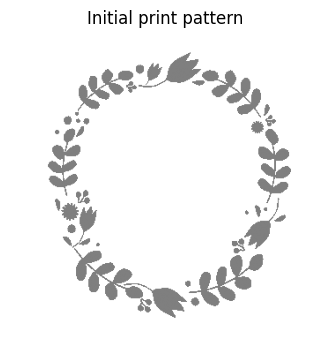

In [ ]:
img_path = upload_image()
img = Image.open(img_path)
mask, H_init, max_heat = image_to_heat_pattern(img_path, cfg)
visualize_init_pattern(H_init, max_heat)

##4. 🔁 Run Optimization and Preview Result
> This process adjusts your image into a print-ready pattern that compensates for heat spread. The simulation is based on the custom parameters you set [here](#scrollTo=jNyYGd1sY4Z_). This is where the magic happens! "Optimization" here means transforming darker/lighter areas so that after heating, the texture matches your original design. This then embeds a preview right here so you can inspect the layout and dark/light regions before downloading.

In [ ]:
%%time
# Set the maximum height of the output
display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 500})'))

# Compute physical dimensions (for logging)
img_w, img_h, phys_w, phys_h = compute_dims(Image.open(img_path))

# Optimize
T_best, H_best, errors = optimize(mask, H_init, max_heat, img_w, img_h, phys_w, phys_h, cfg)
print(f"Optimization completed in {len(errors)} iterations.")

# Save pattern PDF
pattern_pdf = save_pattern(img_path, H_best, max_heat)
print(f"Saved optimized pattern to: {pattern_pdf}")

# Display the generated PDF inline in Colab
with open(pattern_pdf, "rb") as pdf_file:
    encoded_pdf = base64.b64encode(pdf_file.read()).decode('utf-8')
IFrame(f"data:application/pdf;base64,{encoded_pdf}", width=400, height=400)

<IPython.core.display.Javascript object>

2025-08-02 04:14:51,436 [INFO] Iteration 1: Outlier = 10%
2025-08-02 04:14:51,537 [INFO] Iteration 2: Outlier = 7%
2025-08-02 04:14:51,638 [INFO] Iteration 3: Outlier = 6%
2025-08-02 04:14:51,738 [INFO] Iteration 4: Outlier = 6%
2025-08-02 04:14:51,836 [INFO] Iteration 5: Outlier = 5%
2025-08-02 04:14:51,939 [INFO] Iteration 6: Outlier = 5%
2025-08-02 04:14:52,038 [INFO] Iteration 7: Outlier = 5%
2025-08-02 04:14:52,136 [INFO] Iteration 8: Outlier = 5%
2025-08-02 04:14:52,235 [INFO] Iteration 9: Outlier = 5%
2025-08-02 04:14:52,349 [INFO] Iteration 10: Outlier = 4%
2025-08-02 04:14:52,449 [INFO] Iteration 11: Outlier = 4%
2025-08-02 04:14:52,548 [INFO] Iteration 12: Outlier = 4%
2025-08-02 04:14:52,651 [INFO] Iteration 13: Outlier = 4%
2025-08-02 04:14:52,749 [INFO] Iteration 14: Outlier = 4%
2025-08-02 04:14:52,850 [INFO] Iteration 15: Outlier = 4%
2025-08-02 04:14:52,948 [INFO] Iteration 16: Outlier = 3%
2025-08-02 04:14:53,044 [INFO] Iteration 17: Outlier = 3%
2025-08-02 04:14:53,14

Optimization completed in 146 iterations.
Saved optimized pattern to: /content/flower (1)_opt.pdf
CPU times: user 16.2 s, sys: 68.8 ms, total: 16.2 s
Wall time: 16.7 s


##5. 👀 Show Swell Pattern & Temperature Distribution & Optimization Performance

> See side-by-side visualizations of the final raised texture (swell pattern) and temperature across the sheet (temperature distribution), as well as a graph showing how many iterations the optimizer ran and how it improved the pattern.

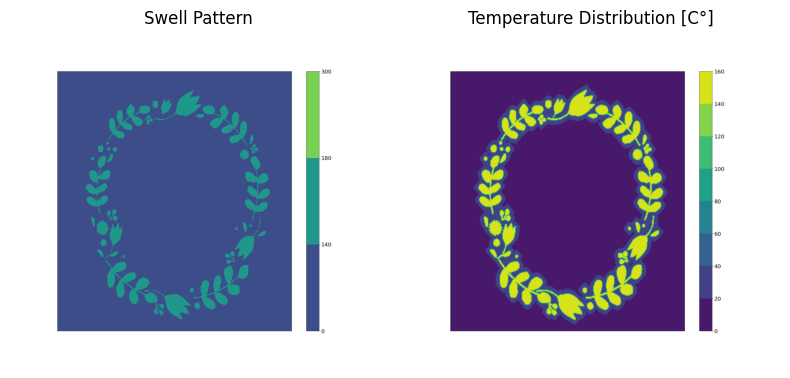

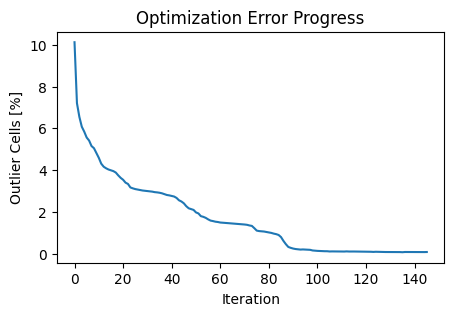

In [ ]:
# Save and display plots with matplotlib
plots = save_plots(T_best, phys_w, phys_h, img_path, dpi=72)
display_plots(plots)
plot_error_progression(errors, cfg)

##6. 💾 Download Optimized Pattern

>Finally, grab the PDF file you just created. You’re ready to print and experiment!

In [ ]:
download_pdf(pattern_pdf)

## 7. Troubleshooting & FAQ

**Q: What file types work?**  
A: You can upload JPG or PNG images.

**Q: My image didn’t upload.**  
A: Make sure you click the **Choose Files** button and pick a valid image. Re-run the cell if it fails.

**Q: I see an error during optimization.**  
A: Check that your file is not too large. Try a smaller image and re-run.

**Q: How long does it take?**  
A: On Colab, it may take a minute or two.

**Tip:** If something goes wrong, restart the notebook (Runtime → Restart runtime) and re-run from the top.

Still having trouble? Contact

[![@RefreshSource](https://img.shields.io/badge/@RefreshSource-black?logo=x&logoColor=white)](https://x.com/refreshsource)
[![Email](https://img.shields.io/badge/sosuke.ichihashi@gmail.com-black?logo=gmail&logoColor=white)](mailto:sosuke.ichihashi@gmail.com)

## 8. Credits & License
###License
>This project is licensed under the [MIT License](https://github.com/sosucat/sbl-optimizer-colab/blob/main/LICENSE).


###Developer
>Sosuke Ichihashi

> [![Sosuke Ichihashi](https://img.shields.io/badge/Sosuke_Ichihashi-black?logo=googlescholar&logoColor=white)](https://sosuke-ichihashi.com/)
[![@sosucat](https://img.shields.io/badge/@sosucat-black?logo=github&logoColor=white)](https://github.com/sosucat)
[![@RefreshSource](https://img.shields.io/badge/@RefreshSource-black?logo=x&logoColor=white)](https://x.com/refreshsource)


###Cite this work
> If you use **sbl-optimizer** in your research or projects, please cite:
* Sosuke Ichihashi, Noura Howell, and HyunJoo Oh. 2025.\
Swell by Light: An Approachable Technique for Freeform Raised Textures. \
In Proceedings of the Nineteenth International Conference on Tangible, Embedded, and Embodied Interaction (TEI '25). Association for Computing Machinery, New York, NY, USA, Article 45, 1–16. https://doi.org/10.1145/3689050.3704420
```bibtex
@inproceedings{10.1145/3689050.3704420,
author = {Ichihashi, Sosuke and Howell, Noura and Oh, HyunJoo},
title = {Swell by Light: An Approachable Technique for Freeform Raised Textures},
year = {2025},
isbn = {9798400711978},
publisher = {Association for Computing Machinery},
address = {New York, NY, USA},
url = {https://doi.org/10.1145/3689050.3704420},
doi = {10.1145/3689050.3704420},
booktitle = {Proceedings of the Nineteenth International Conference on Tangible, Embedded, and Embodied Interaction},
articleno = {45},
numpages = {16},
keywords = {2.5D fabrication, Personal fabrication, tactile rendering},
location = {Bordeaux / Talence, France},
series = {TEI '25}
}
```

## 9. Next Steps
**Ready for more? Here’s where to explore further:**


🎨 **Fabrication Tutorial**

> See the step-by-step fabrication tutorial on our website and YouTube.

>[![Fabrication](https://img.shields.io/badge/🔗_Fabrication-black)](https://sites.gatech.edu/futurefeelings/2025/07/23/make-puffy-patterns-with-light/)
[![Watch fabrication demo on YouTube](https://img.shields.io/badge/Fabrication-750014?logo=youtube)](https://youtu.be/LomVS_jHxl0?feature=shared)


🔗 **Project Page**

> Read more about the project and example applications on our project page.

>[![Project page](https://img.shields.io/badge/🔗_Project_Page-black)](https://sites.gatech.edu/futurefeelings/2025/03/07/swell-by-light-tei-25/)


📄 **Research Paper**

> Explore various application examples of Swell by Light and learn the theory and related work behind it in our paper.

>[![Research paper](https://img.shields.io/badge/Research_Paper-black?logo=acm)](https://doi.org/10.1145/3689050.3704420)



🦄 **Advanced Colab Notebook**

> Check out this advanced version to understand the codes in detail.

>[![Advanced Colab](https://img.shields.io/badge/Advanced_Colab_Notebook-black?logo=googlecolab)](https://sites.gatech.edu/futurefeelings/2025/03/07/swell-by-light-tei-25/)



👩‍💻 **Local Command Line Interface**

> Follow the tutorials on PyPI or GitHub to use sbl-optimizer in a simpler way on your machine.

>[![PyPI version](https://badge.fury.io/py/sbl-optimizer.svg)](https://badge.fury.io/py/sbl-optimizer)
[![GitHub](https://img.shields.io/badge/sbl--optimizer-black?logo=github)](https://github.com/sosucat/sbl-optimizer)


👨‍💻 **Source Code & Issues**

> Visit our GitHub repository to report issues, contribute, or see the latest developments.

>[![GitHub sbl-optimizer](https://img.shields.io/badge/sbl--optimizer-black?logo=github)](https://github.com/sosucat/sbl-optimizer)
[![GitHub sbl-optimizer-colab-simple](https://img.shields.io/badge/This_Notebook-black?logo=github)](https://github.com/sosucat/sbl-optimizer-colab-simple)


🕵️‍♂️ **Author’s Website**

> Discover more work by Sosuke Ichihashi.

>[![Author](https://img.shields.io/badge/Author-black?logo=googlescholar&logoColor=white)](https://sosuke-ichihashi.com/)


*Happy fabricating!*